<a href="https://www.bigdatauniversity.com"><img src = "https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width = 400, align = "center"></a>
# <center>K-Nearest Neighbors</center>

In this Lab you will load a customer dataset, fit the data, and use K-Nearest Neighbors to predict a data point. But what is **K-Nearest Neighbors**?

**K-Nearest Neighbors** is an algorithm for supervised learning. Where the data is 'trained' with data points corresponding to their classification. Once a point is to be predicted, it takes into account the 'K' nearest points to it to determine it's classification.

### Here's an visualization of the K-Nearest Neighbors algorithm.

<img src = "https://ibm.box.com/shared/static/mgkn92xck0z05v7yjq8pqziukxvc2461.png">

In this case, we have data points of Class A and B. We want to predict what the star (test data point) is. If we consider a k value of 3 (3 nearest data points) we will obtain a prediction of Class B. Yet if we consider a k value of 6, we will obtain a prediction of Class A.

In this sense, it is important to consider the value of k. But hopefully from this diagram, you should get a sense of what the K-Nearest Neighbors algorithm is. It considers the 'K' Nearest Neighbors (points) when it predicts the classification of the test point.

Lets load requiered libraries

In [76]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics


### About dataset

Imagine a telecommunications provider has segmented its customer base by service usage patterns, categorizing the customers into four groups. If demographic data can be used to predict group membership, the company can customize offers for individual prospective customers. It is a classification problem. That is, given the dataset,  with predefined labels, we need to build a model to be used to predict class of a new or unknown case. 

The example focuses on using demographic data, such as region, age, and marital, to predict usage patterns. 

The target field, called __custcat__, has four possible values that correspond to the four customer groups, as follows:
  1- Basic Service
  2- E-Service
  3- Plus Service
  4- Total Service

Our objective is to build a classifier, to predict the class of unknown cases. We will use a specific type of classification called K nearest neighbour.


Lets download the dataset. To download the data, we will use !wget to download it from IBM Object Storage.

__Did you know?__ When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)

### Load Data From CSV File  

In [77]:
df = pd.read_csv('stroke.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Data Visualization and Anylisis 



#### Let’s see how many of each class is in our data set 

In [78]:
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

#### 281 Plus Service, 266 Basic-service, 236 Total Service, and 217 E-Service customers


You can easily explore your data using visualization techniques:

array([[<AxesSubplot:title={'center':'stroke'}>]], dtype=object)

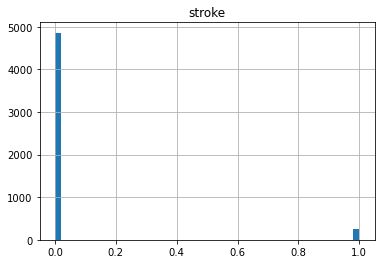

In [79]:
df.hist(column='stroke', bins=50)

### Feature set

Lets defind feature sets, X:

In [80]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

To use scikit-learn library, we have to convert the Pandas data frame to a Numpy array:

In [81]:
varint = ['avg_glucose_level', 'bmi']
df[varint] = df[varint].astype("float")
varfloat = ['id','age','hypertension','heart_disease']
df[varfloat] = df[varfloat].astype("int")

avg_norm_loss = df['bmi'].astype("float").mean(axis=0)
df['bmi'].replace(np.nan, avg_norm_loss, inplace=True)

df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


What are our lables?

In [82]:
X = df[['age','hypertension','heart_disease','avg_glucose_level','bmi','stroke']].values 
X[0:5]
y = df['stroke'].values
y[0:5]

array([1, 1, 1, 1, 1], dtype=int64)

## Normalize Data 

Data Standardization give data zero mean and unit variance, it is good practice, especially for algorithms such as KNN which is based on distance of cases:

In [83]:
df.dtypes

id                     int32
gender                object
age                    int32
hypertension           int32
heart_disease          int32
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### Train Test Split  
Out of Sample Accuracy is the percentage of correct predictions that the model makes on data that that the model has NOT been trained on. Doing a train and test on the same dataset will most likely have low out-of-sample accuracy, due to the likelihood of being over-fit.

It is important that our models have a high, out-of-sample accuracy, because the purpose of any model, of course, is to make correct predictions on unknown data. So how can we improve out-of-sample accuracy? One way is to use an evaluation approach called Train/Test Split.
Train/Test Split involves splitting the dataset into training and testing sets respectively, which are mutually exclusive. After which, you train with the training set and test with the testing set. 

This will provide a more accurate evaluation on out-of-sample accuracy because the testing dataset is not part of the dataset that have been used to train the data. It is more realistic for real world problems.


In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (4088, 6) (4088,)
Test set: (1022, 6) (1022,)


# Classification 

## K nearest neighbor (K-NN)

#### Import library 

Classifier implementing the k-nearest neighbors vote.

### Training

Lets start the algorithm with k=4 for now:

In [85]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors=k)
neigh.fit(X_train, y_train)
neigh

KNeighborsClassifier(n_neighbors=4)

### Predicting
we can use the model to predict the test set:

In [86]:
yhat = neigh.predict(X_test)
yhat[0:5]

array([0, 0, 0, 0, 0], dtype=int64)

### Accuracy evaluation
In multilabel classification, __accuracy classification score__ function computes subset accuracy. This function is equal to the jaccard_similarity_score function. Essentially, it calculates how match the actual labels and predicted labels are in the test set.

In [87]:

print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.952054794520548
Test set Accuracy:  0.9500978473581213


## Practice
Can you build the model again, but this time with k=6?

In [88]:
# write your code here




Double-click __here__ for the solution.

<!-- Your answer is below:
    
    
k = 6
neigh6 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat6 = neigh6.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh6.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat6))

-->

#### What about other K?
K in KNN, is the number of nearest neighbors to examine. It is supposed to be specified by User. So, how we choose right K?
The general solution is to reserve a part of your data for testing the accuracy of the model. Then chose k =1, use the training part for modeling, and calculate the accuracy of prediction using all samples in your test set. Repeat this process, increasing the k, and see which k is the best for your model.

We can calucalte the accuracy of KNN for different Ks.

In [89]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.93150685, 0.94716243, 0.94227006, 0.95009785, 0.94911937,
       0.95107632, 0.95009785, 0.95107632, 0.94911937])

#### Plot  model accuracy  for Different number of Neighbors 

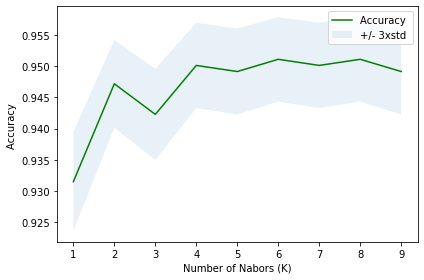

In [90]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [91]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.9510763209393346 with k= 6


## Want to learn more?

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: [SPSS Modeler](http://cocl.us/ML0101EN-SPSSModeler).

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at [Watson Studio](https://cocl.us/ML0101EN_DSX)

### Thanks for completing this lesson!

Notebook created by: <a href = "https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>

<hr>
Copyright &copy; 2018 [Cognitive Class](https://cocl.us/DX0108EN_CC). This notebook and its source code are released under the terms of the [MIT License](https://bigdatauniversity.com/mit-license/).​